In [25]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [53]:
duration = 10000. # ms
dt = 1  # ms
t = np.arange(0., duration, dt)

exc_peak_rate = 10.
exc_theta_depth = 0.8

exc_freq = 7 # Hz

baseline_rate = (1 - exc_theta_depth)
phase_offset = 0.  # np.pi / 4.
exc_i_syn_theta_mod = exc_theta_depth * (np.cos(2. * np.pi * exc_freq * t / 1000. + phase_offset) + 1.) / 2. + baseline_rate

<IPython.core.display.Javascript object>


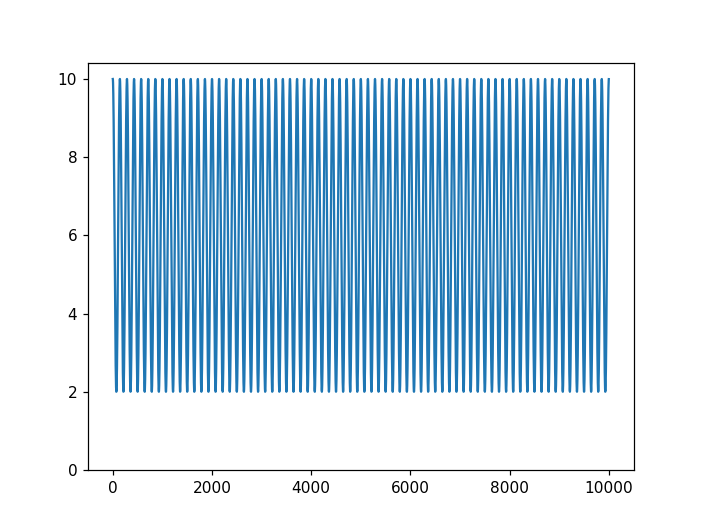

(0.0, 10.4)

In [54]:
plt.figure()
plt.plot(t, exc_peak_rate * exc_i_syn_theta_mod)
ylim = plt.ylim()
plt.ylim(0., ylim[1])

In [55]:
window_dur = 2. # sec
window_len = int(window_dur * 1000 / dt)
theta_filter = scipy.signal.firwin(window_len, [4., 10.], nyq=1000./2./dt, pass_zero=False)
trace = exc_i_syn_theta_mod
un_padded_filtered = scipy.signal.filtfilt(theta_filter, [1.], trace)

<IPython.core.display.Javascript object>


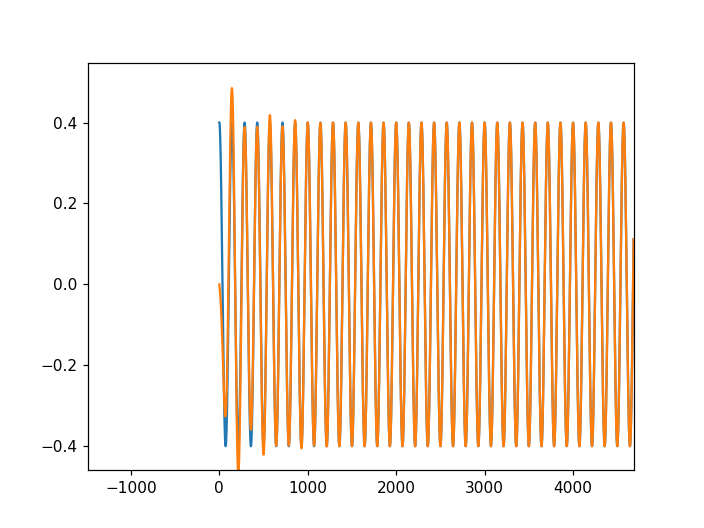

(0.0, 0.5328883176677027)

In [56]:
plt.figure()
plt.plot(t, trace - np.mean(trace))
plt.plot(t, un_padded_filtered)
ylim = plt.ylim()
plt.ylim(0., ylim[1])

In [57]:
pad_len = int(window_len / 2.)
padded_trace = np.zeros(len(trace) + window_len)
padded_trace[pad_len:-pad_len] = trace
padded_trace[:pad_len] = trace[::-1][-pad_len:]
padded_trace[-pad_len:] = trace[::-1][:pad_len]

<IPython.core.display.Javascript object>


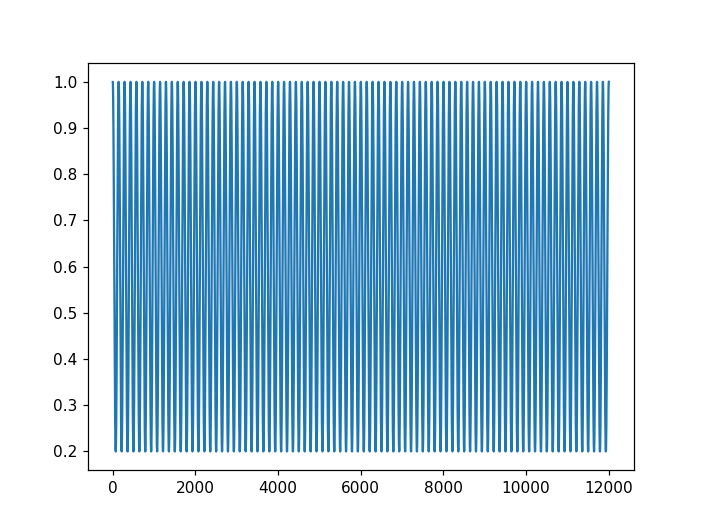

In [58]:
plt.figure()
plt.plot(padded_trace)

In [63]:
padded_filtered = scipy.signal.filtfilt(theta_filter, [1.], padded_trace)
filtered_trace = padded_filtered[pad_len:-pad_len]

<IPython.core.display.Javascript object>


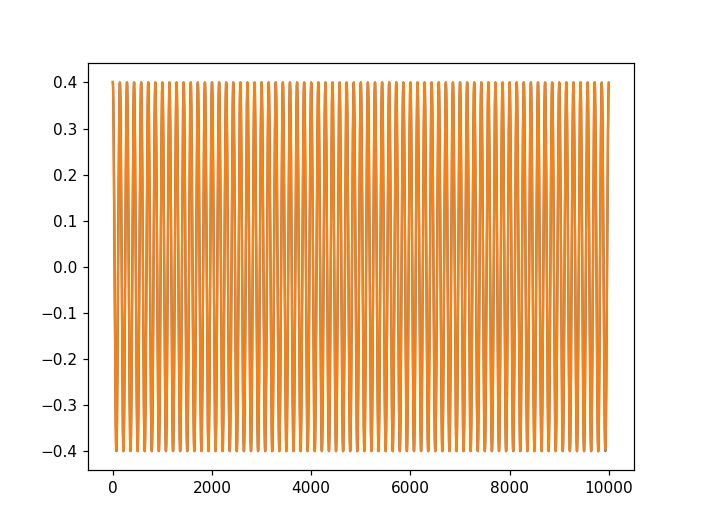

In [66]:
plt.figure()
plt.plot(t, trace - np.mean(trace))
plt.plot(t, filtered_trace)

In [88]:
reference = trace - np.mean(trace)
ref_analytic_signal = scipy.signal.hilbert(reference)
ref_amplitude_envelope = np.abs(ref_analytic_signal)
# reference_phase = np.unwrap(np.angle(ref_analytic_signal))
reference_phase = np.angle(ref_analytic_signal)

<IPython.core.display.Javascript object>


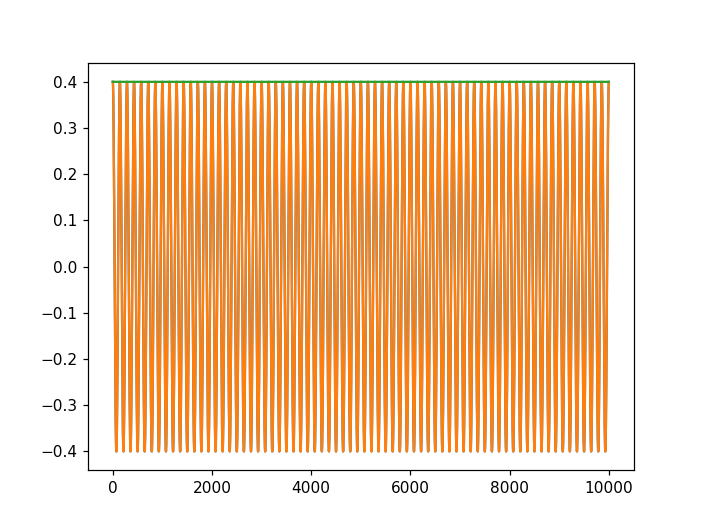

/Users/aaronmil/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


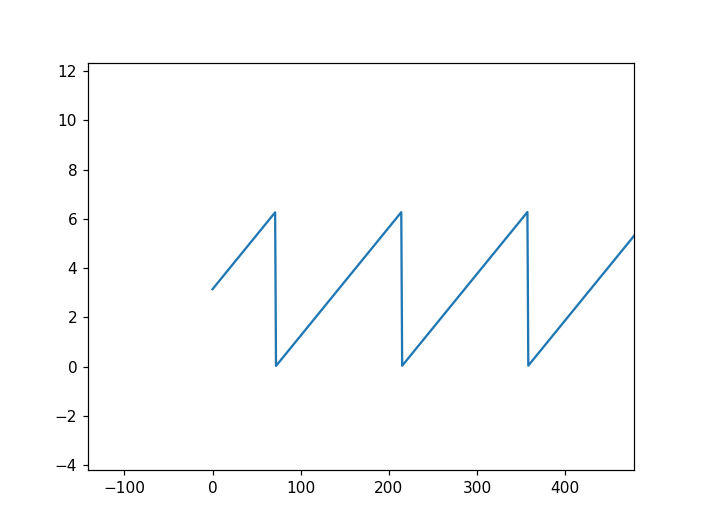

In [90]:
plt.figure()
plt.plot(t, reference)
plt.plot(t, ref_analytic_signal)
plt.plot(t, ref_amplitude_envelope)

plt.figure()
# plt.plot(t, reference_phase % (2. * np.pi))
plt.plot(t, reference_phase + np.pi)

In [91]:
np.__version__

'1.19.2'